In [7]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling1D, ZeroPadding1D, Flatten, Reshape, Conv1D, BatchNormalization, Activation
from keras import regularizers
from sklearn.model_selection import train_test_split

import torch
from torch.utils import data

from magnet.src.data_reader.dataset import TotalMagnetDataset
from magnet.src.model.model import CDCK2

In [8]:
q001_data_raw = np.load('/data1/ryan/train-files/train_q001_bot.npy')
q003_data_raw = np.load('/data1/ryan/train-files/train_q003_bot.npy')
q076_data_raw = np.load('/data1/ryan/train-files/train_q076_bot.npy')
q103_data_raw = np.load('/data1/ryan/train-files/train_q103_bot.npy')

#don't normalize over the whole quench, normalize each image
q001_data = np.zeros_like(q001_data_raw)
q003_data = np.zeros_like(q003_data_raw)
q076_data = np.zeros_like(q076_data_raw)
q103_data = np.zeros_like(q103_data_raw)

q001_max = np.max(q001_data_raw[:,:])
q003_max = np.max(q003_data_raw[:,:])
q076_max = np.max(q076_data_raw[:,:])
q103_max = np.max(q103_data_raw[:,:])

#it's not pretty but it works
for i, im in enumerate(q001_data_raw):
    q001_data[i,:] = q001_data_raw[i,:] / q001_max

for i, im in enumerate(q003_data_raw):
    q003_data[i,:] = q003_data_raw[i,:] / q001_max
    
for i, im in enumerate(q076_data_raw):
    q076_data[i,:] = q076_data_raw[i,:] / q001_max
    
for i, im in enumerate(q103_data_raw):
    q103_data[i,:] = q103_data_raw[i,:] / q001_max

In [9]:
qall_data = np.concatenate((q001_data, q003_data, q076_data, q103_data), axis=0)
print(qall_data.shape)
data_mod = np.empty((qall_data.shape[0], qall_data.shape[1], 1))
data_mod[:, :, 0] = qall_data

x_train_temp, x_test_temp = train_test_split(qall_data, random_state=42)
print(x_train_temp.shape)
print(x_test_temp.shape)

x_train = np.empty((x_train_temp.shape[0], x_train_temp.shape[1], 1))
x_test = np.empty((x_test_temp.shape[0], x_test_temp.shape[1], 1))
x_train[:, :, 0] = x_train_temp
x_test[:, :, 0] = x_test_temp

print(x_train.shape)
print(x_test.shape)

(22820, 2000)
(17115, 2000)
(5705, 2000)
(17115, 2000, 1)
(5705, 2000, 1)


In [14]:
batch = 1
timestep = 12
audio_window = 2000

model = CDCK2(timestep, batch, audio_window).to('cuda')
model.load_state_dict(torch.load('/data1/ryan/snapshot/cdc/cdc-2019-11-04_12_13_11-model_best.pth')['state_dict'])
model.eval()

# autoencoder = load_model('case_2_autoencoder_conv.h5')
# decoder = Model(inputs=autoencoder.get_layer('up_sampling1d_1').input, outputs=autoencoder.output)
# decoder.summary()

# encoder_path = '/data1/ryan/snapshot/cdc/cdc-2019-08-30_14_08_28-model_best.pth'
# decoder_path_1 = '/data1/ryan/decoder/snapshot/cdc/cdc-2019-08-30_14_13_39-model_best.pth'
# decoder_path_2 = '/data1/ryan/decoder/snapshot/cdc/cdc-2019-08-30_14_14_21-model_best.pth'

# encoder = CDCK2(timestep, batch, audio_window).to("cuda")
# encoder.load_state_dict(torch.load(encoder_path)['state_dict'])
# encoder.eval()

# decoder1 = Transposed().to("cuda")
# decoder1.load_state_dict(torch.load(decoder_path_1)['state_dict'])
# decoder1.eval()

# decoder2 = Transposed().to("cuda")
# decoder2.load_state_dict(torch.load(decoder_path_2)['state_dict'])
# decoder2.eval()

CDCK2(
  (encoder): Sequential(
    (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), padding=(3,), bias=False)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(512, 512, kernel_size=(8,), stride=(5,), padding=(2,), bias=False)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(512, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_

In [11]:
total_set = TotalMagnetDataset('', '', audio_window)
params = {'num_workers': 0,
          'pin_memory': False}
final_loader = data.DataLoader(total_set, batch_size=batch, shuffle=False, **params)

# train_raw = '/data1/ryan/dataset/training_bot_ch2.h5'
# train_list = '/data1/ryan/dataset/training_bot_ch2.txt'

# training_set = Dataset(train_raw, train_list, audio_window)
# train_loader = data.DataLoader(training_set, batch_size=batch, shuffle=True, **params)

In [ ]:
encoded_all = []

for batch_idx, ex in enumerate(final_loader):
    ex = ex.float().unsqueeze(1).to('cuda')  # add channel dimension
    hidden = model.init_hidden(len(ex), use_gpu=True)
    pred = model.pred(ex, hidden).tolist()
    
    
    break

encoded_all = np.array(encoded_all)
print(encoded_all.shape)

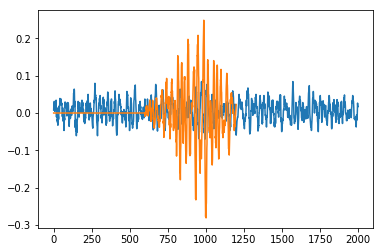

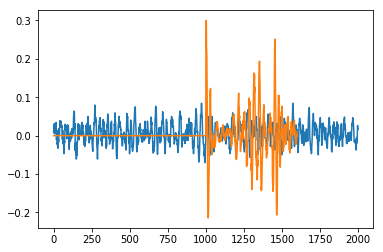

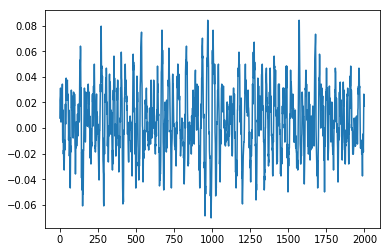

In [7]:
for batch_idx, ex in enumerate(train_loader):
    ex = ex.float().unsqueeze(1).to('cuda')  # add channel dimension
    hidden = encoder.init_hidden(len(ex), use_gpu=True)
    pred1 = encoder.predict(ex, hidden, 1)
    pred2 = encoder.predict(ex, hidden, 2)

    pred1 = pred1.transpose(0, 1)
    pred1 = pred1.transpose(1, 2)
    pred2 = pred2.transpose(0, 1)
    pred2 = pred2.transpose(1, 2)

    result1 = decoder1.decoder(pred1).view(-1).detach().cpu().numpy()
    result2 = decoder2.decoder(pred2).view(-1).detach().cpu().numpy()

    result1 = np.append(np.zeros(600), result1)
    result2 = np.append(np.zeros(1000), result2)
    ex = ex.view(-1).cpu().numpy()

    plt.figure()
    plt.plot(ex)
    plt.plot(result1)
    plt.show()
    
    plt.figure()
    plt.plot(ex)
    plt.plot(result2)
    plt.show()
    
    plt.figure()
    plt.plot(ex)
    plt.show()

    break